In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torchvision
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm
from matplotlib import pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score, average_precision_score,auc,roc_curve, precision_recall_fscore_support

import resplot

## Set parameters and define helper functions

In [2]:
DEVICE = th.device("cuda:0" if th.cuda.is_available() else "cpu")

args = dict()
args['dim_h'] = 40         # factor controlling size of hidden layers
args['n_channel'] = 1      # number of channels in the input data (MNIST = 1, greyscale)
args['n_z'] = 20           # number of dimensions in latent space. 
args['sigma'] = 2.0        # variance in n_z
args['lr'] = 0.0001        # learning rate for Adam optimizer
args['epochs'] = 401       # how many epochs to run for
args['batch_size'] = 2048   # batch size for SGD
args['save'] = False       # save weights at each epoch of training if True
args['train'] = True       # train networks if True, else load networks from saved weights

args['scheduler'] = True   # use scheduler for learning rate or not
args['inClass'] = 0        # set which is the class of the inliers

args['subspace_reg']=0.0   # weight for subspace regularization, 0 if not applied
args['wae']=1.0            # WAE-GAN discriminator lambda, 0 if not WAE
args['lipschitz']=0        # Lipschitz penalty weight, 0 if not applied
args['advantage']=True     # Advantage penalty 

args['outratio'] = 0.3     # outlier ration in unlabeled dataset

seed = 2
np.random.seed(seed)
th.manual_seed(seed)

zero = th.tensor([0], dtype=th.float).cuda().to(DEVICE)
one = th.tensor([1], dtype=th.float).cuda().to(DEVICE)

#USEFUL FUNCTIONS

# methods to freeze/free parameters for optimization
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False
        
def min_max_normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    return tensor


## Neural Networks for Encoder, Decoders, Discriminator

In [3]:
class WAE_Encoder(nn.Module):
    def __init__(self, args):
        super(WAE_Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
        )
        
        # final layer is fully connected
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)
    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze()
        x = self.fc(x)
        return x

class WAE_Decoder(nn.Module):
    def __init__(self, args):
        super(WAE_Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),
            nn.ReLU()
        )

        # deconvolutional filters, essentially the inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 8, 7, 7)
        x = self.deconv(x)
        return x



# define the descriminator
class Discriminator(nn.Module):
    def __init__(self, args):
        super(Discriminator, self).__init__()

        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # main body of discriminator, returns [0,1]
        self.main = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x

## Prepare dataset

In [4]:
#Download MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = datasets.MNIST(root = 'data', train = True, download = True, transform = img_transform)
testset = datasets.MNIST(root = 'data', train = False, download = True, transform = img_transform)


#Get unlabeled dataset from testing
testIN = min_max_normalization(testset.test_data[np.where(testset.test_labels == args['inClass'])].type('torch.FloatTensor'),0.0,1.0)
testOUT = min_max_normalization(testset.test_data[np.where(testset.test_labels != args['inClass'])].type('torch.FloatTensor'),0.0,1.0)

#We want to have the same size of data for all the runs, even when we change the outlier ratio.
#We consider outlier ratio from 0.1 to 0.5. Thus, inlier ratio from 0.9 to 0.5
#Given that usually inlier class is only one and outliers all the rest, with 0.1 outlier ratio and 0.9
#inlier ratio we have the smallest unlabeled dataset, we will use this size for the unlabeled dataset.
maxInlierRatio = 0.9
unlabeledSize = int(testIN.shape[0]*(1.0/maxInlierRatio))

outSize = int(unlabeledSize * args['outratio'])
inSize = int(unlabeledSize * (1-args['outratio']))
#Update unlabeledSize given that the above rounding may change the total
unlabeledSize = outSize + inSize
unlabeledOUT = testOUT[:outSize]
unlabeledIN = testIN[:inSize]

unlabeled = np.concatenate((unlabeledIN,unlabeledOUT))

unlabeled_labels = np.concatenate((np.zeros(inSize),np.ones(outSize)))


#reshape for convolutional and convert
unlabeled = th.FloatTensor(unlabeled.reshape(-1,1,28,28)).cuda().to(DEVICE)

#Shuffle the unlabeled data, otherwise in the training it will see first all the inliers, then the outliers
shuffle_idx = np.arange(unlabeledSize)
np.random.shuffle(shuffle_idx)
unlabeled = unlabeled[shuffle_idx]
unlabeled_labels = unlabeled_labels[shuffle_idx]

#Get training data from training set

trainIN = min_max_normalization(trainset.train_data[np.where(trainset.train_labels == args['inClass'])].type('torch.FloatTensor'),0.0,1.0)
trainOUT = min_max_normalization(trainset.train_data[np.where(trainset.train_labels != args['inClass'])].type('torch.FloatTensor'),0.0,1.0)
trainOUT = trainOUT[:outSize] #training set is 6 times testing set so we can use more data
trainIN = trainIN[:inSize] #training set is 6 times testing set so we can use more data

train = np.concatenate((trainIN,trainOUT))
train_labels = np.concatenate((np.zeros(inSize),np.ones(outSize)))

#Reshape for convolutional net and convert
train = th.FloatTensor(train.reshape(-1,1,28,28)).cuda().to(DEVICE)

#Shuffle training data
shuffle_idxT = np.arange(train.shape[0])
np.random.shuffle(shuffle_idxT)
train = train[shuffle_idxT]
train_labels = train_labels[shuffle_idxT]
#reshape for convolutional and convert


train_loader = DataLoader(
    dataset=train,
    batch_size=args['batch_size'],
    drop_last=False,
    shuffle=False
)

labels_loader = DataLoader(
    dataset=th.FloatTensor(train_labels).cuda().to(DEVICE),
    batch_size=args['batch_size'],
    drop_last=False,
    shuffle=False
)

## Initialize models and optimizers

In [5]:
error = nn.MSELoss(reduction='none')
criterion = nn.MSELoss()

encoder = WAE_Encoder(args).cuda().to(DEVICE)
decoderI = WAE_Decoder(args).cuda().to(DEVICE)
decoderO = WAE_Decoder(args).cuda().to(DEVICE)
discriminator = Discriminator(args).cuda().to(DEVICE)

enc_optim = th.optim.Adam(encoder.parameters(), lr = args['lr'])
decI_optim = th.optim.Adam(decoderI.parameters(), lr = args['lr'])
decO_optim = th.optim.Adam(decoderO.parameters(), lr = args['lr'])
dis_optim = th.optim.Adam(discriminator.parameters(), lr = args['lr'])

if args['scheduler']:
    enc_scheduler = th.optim.lr_scheduler.StepLR(enc_optim, step_size=30, gamma=0.5)
    decI_scheduler = th.optim.lr_scheduler.StepLR(decI_optim, step_size=30, gamma=0.5)
    decO_scheduler = th.optim.lr_scheduler.StepLR(decO_optim, step_size=30, gamma=0.5)
    dis_scheduler = th.optim.lr_scheduler.StepLR(dis_optim, step_size=30, gamma=0.5)

## Supervised training 

In [10]:
print("Epoch\tLoss\tAdv\tPrec\tRec\tF1\tAUC")
advantageI = 0.0
for epoch in range(args['epochs']):
    for cnt, x in enumerate(zip(train_loader, labels_loader)):
        #split the dataset int positive p, unlabeled u, both combined x
        t = x[0]
        y_true = x[1]
        
        #zero the gradients
        encoder.zero_grad()
        decoderI.zero_grad()
        decoderO.zero_grad()
        discriminator.zero_grad()
        
        if args['wae'] > 0:
            ###################### TRAIN DISCRIMINATOR ######################

            # freeze auto encoder params
            frozen_params(decoderI)
            frozen_params(decoderO)
            frozen_params(encoder)
            # free discriminator params
            free_params(discriminator)

            # run discriminator against randn draws
            z = (th.randn(t.size()[0], args['n_z']) * args['sigma']).cuda().to(DEVICE)
            d_z = discriminator(z)

            # run discriminator against encoder z's
            z_hat = encoder(t)
            d_z_hat = discriminator(z_hat)

            d_z_loss = args['wae']*th.log(d_z).mean()
            d_z_hat_loss = args['wae']*th.log(1 - d_z_hat).mean()

            # formula for ascending the descriminator -- -one reverses the direction of the gradient.
            d_z_loss.backward(-one)
            d_z_hat_loss.backward(-one)

            dis_optim.step()
        
        
        ###################### TRAIN AUTOENCODER ######################

        # flip which networks are frozen, which are not
        free_params(decoderI)
        free_params(decoderO)
        free_params(encoder)
        frozen_params(discriminator)


        # encode positive and unlabeled
        z_hatT = encoder(t)
        
        # decode training with inlier and outlier decoder
        x_hatTI = decoderI(z_hatT)
        x_hatTO = decoderO(z_hatT)
                
        lossTI = error(x_hatTI,t).mean(axis=(1,2,3))
        lossTO = error(x_hatTO,t).mean(axis=(1,2,3))
    

        # compute y based on the decoder with lower error.
        #y = (lossUO<lossUI).float()
        
        normmax = th.norm(x_hatTO, p=1,dim=(1,2,3)).max()*0.0001
        
        # compute competitive AE loss
        loss = th.mean(y_true*lossTO + (1-y_true)*lossTI) + 0.01*normmax

        if(args['subspace_reg']>0):
            z_hat = th.cat((z_hatP,z_hatU),0)
            ws = th.exp(-th.pdist(t.reshape(t.shape[0],-1)/args['subspace_reg'],2))
            o_len = (int)(t.shape[0]/4)
            ws[-o_len:]=0
            diff = th.pow(th.pdist(z_hat,1),2)
            loss += args['subspace_reg'] * th.mean(ws*diff)
        
        if(args['wae'])>0: 
            z_hat = encoder(t)
            # discriminate latents        
            d_z_hat = discriminator(z_hat)
            # calculate discriminator loss
            d_loss = args['wae'] * (th.log(d_z_hat)).mean()
            # compute gradient to fool discriminator
            d_loss.backward(-one)
            
        loss.backward(one)
        
        enc_optim.step()
        decI_optim.step()
        decO_optim.step()
        
    
    if epoch % 20 == 0:
        x_hatUI = decoderI(encoder(unlabeled))
        x_hatUO = decoderO(encoder(unlabeled))
        lossUI = error(x_hatUI,unlabeled).mean(axis=(1,2,3))
        lossUO = error(x_hatUO,unlabeled).mean(axis=(1,2,3))
        
        y_pred = list((lossUO<lossUI).float().cpu())
        precision, recall, F1, _ = precision_recall_fscore_support(unlabeled_labels,
                                                               y_pred,
                                                               average='binary')
        AUC = roc_auc_score(unlabeled_labels,y_pred)
        
        print("%d\t%1.3f\t%1.3f\t%1.3f\t%1.3f\t%1.3f\t%1.3f" % (epoch,loss.item(),advantageI,precision, recall,F1,AUC))
    
        

Epoch	Loss	Adv	Prec	Rec	F1	AUC
0	0.039	0.000	0.941	0.985	0.963	0.979
20	0.037	0.000	0.952	0.969	0.960	0.974
40	0.037	0.000	0.966	0.969	0.968	0.977
60	0.036	0.000	0.973	0.985	0.979	0.986
80	0.032	0.000	0.984	0.966	0.975	0.980
100	0.031	0.000	0.984	0.951	0.967	0.972
120	0.031	0.000	0.975	0.969	0.972	0.979
140	0.029	0.000	0.954	0.960	0.957	0.970
160	0.028	0.000	0.978	0.945	0.961	0.968
180	0.028	0.000	0.988	0.969	0.978	0.982
200	0.024	0.000	0.987	0.960	0.974	0.977
220	0.025	0.000	0.978	0.969	0.974	0.980
240	0.026	0.000	0.955	0.969	0.962	0.975
260	0.025	0.000	0.973	0.979	0.976	0.983
280	0.023	0.000	0.944	0.982	0.962	0.978
300	0.022	0.000	0.961	0.988	0.974	0.985
320	0.021	0.000	0.979	0.985	0.982	0.988
340	0.019	0.000	0.976	0.988	0.982	0.989
360	0.020	0.000	0.964	0.985	0.974	0.984
380	0.018	0.000	0.981	0.972	0.977	0.982
400	0.017	0.000	0.988	0.969	0.978	0.982


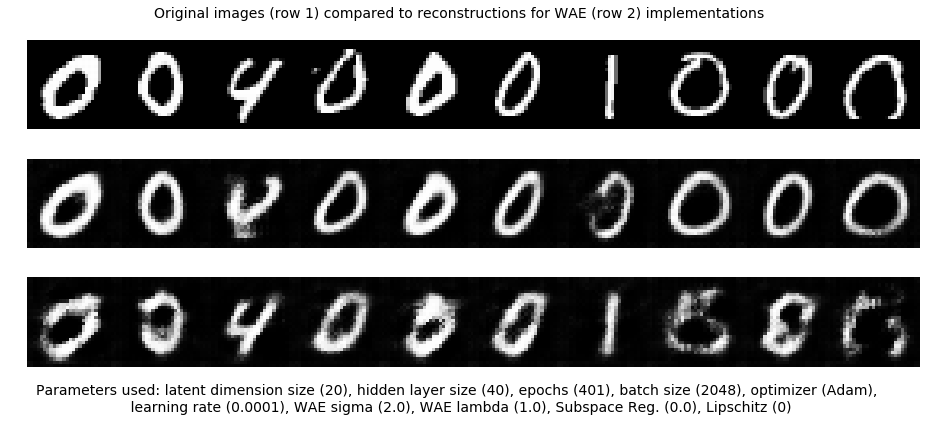

In [12]:
resplot.plot_rows(unlabeled[10:],args,encoder,decoders = [decoderI,decoderO], seed = seed)

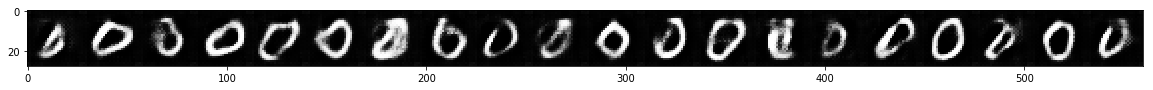

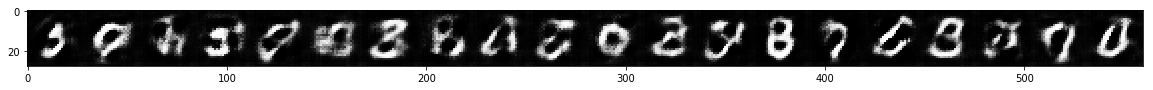

In [13]:
z = (th.randn(20, args['n_z']) * args['sigma']).cuda().to(DEVICE)
generatedI = decoderI(z)
generatedO = decoderO(z)
plt.figure(figsize = (20,2))
plt.imshow(np.stack([generatedI.reshape((-1,28,28)).cpu().detach().numpy()[i].transpose() for i in range(20)]).reshape(-1,28).transpose(), cmap = "gray")
plt.show()
plt.figure(figsize = (20,2))
plt.imshow(np.stack([generatedO.reshape((-1,28,28)).cpu().detach().numpy()[i].transpose() for i in range(20)]).reshape(-1,28).transpose(), cmap = "gray")
plt.show()

In [11]:
th.norm(t, p=1,dim=(1,2,3)).max()*0.0001

tensor(0.0278, device='cuda:0')

In [ ]:
loss

In [ ]:
th.norm(generatedI, p=1,dim=(1,2,3)).mean()